# Discord Chat Text Analysis

Analysing the Discord Chat, "66DaysOfData". Channels:#progress and #general

## Importing libraries


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import spacy

from spacy.matcher import PhraseMatcher
from spacy import displacy

spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm", disable=['ner'])

import json
import os

%matplotlib inline

In [2]:
os.listdir()

['.git',
 '.gitignore',
 '.ipynb_checkpoints',
 '66DaysofData - important - general [749395801482199107].json',
 '66DaysofData - important - introductions [749414833275011074].json',
 '66DaysofData - important - progress [749516705734197258].json',
 'discord.env',
 'discordBotcode.py',
 'progressDiscordChatAnalysis.ipynb',
 'README.md',
 'test.py']

## Loading Data

Loading data into dataframes using `.json_normalize()`. I find the `.json` files have more infomation that the `.csv` files.

In [3]:
filename_gen = '66DaysofData - important - general [749395801482199107].json'   # 21-09-2020 NZT #general channel chat
filename_prog = '66DaysofData - important - progress [749516705734197258].json' # 21-09-2020 NZT #progress channel chat
filename_intro = '66DaysofData - important - introductions [749414833275011074].json' # 21-09-2020 NZT #introductions channel chat

def load_json_to_df(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return pd.json_normalize(data, record_path='messages')

df_gen = load_json_to_df(filename_gen)
df_prog = load_json_to_df(filename_prog)
df_intro = load_json_to_df(filename_intro)

## Exploratory Data Analysis - #progress channel

In [4]:
df_prog.shape

(1741, 15)

In [5]:
df_prog.head()

,id,type,timestamp,timestampEdited,callEndedTimestamp,isPinned,content,attachments,embeds,reactions,author.id,author.name,author.discriminator,author.isBot,author.avatarUrl
0,749937010868748351,Default,2020-08-31T10:21:56.547+00:00,None,None,False,Day1: Created a GitHub repo. Created an R and ...,[],[],"[{'emoji': {'id': None, 'name': '💯', 'isAnimat...",715593892438736898,William Guesdon,3961,False,https://cdn.discordapp.com/embed/avatars/1.png
1,750045262277378089,Default,2020-08-31T17:32:05.694+00:00,None,None,False,> Day1: Created a GitHub repo. Created an R an...,[],[],"[{'emoji': {'id': None, 'name': '👍', 'isAnimat...",743513993250996376,Andrew from DataLeap,8501,False,https://cdn.discordapp.com/avatars/74351399325...
2,750067004639281224,Default,2020-08-31T18:58:29.477+00:00,None,None,False,Thank you @Andrew from DataLeap It can definit...,[],[],[],715593892438736898,William Guesdon,3961,False,https://cdn.discordapp.com/embed/avatars/1.png
3,750068015126544485,Default,2020-08-31T19:02:30.396+00:00,None,None,False,"Guys i am a beginner , would appreciate if you...",[],[],[],750065427107020843,vc,3696,False,https://cdn.discordapp.com/embed/avatars/1.png
4,750070203576221857,Default,2020-08-31T19:11:12.163+00:00,None,None,False,"Hi Guys, Started with basic Stat",[],[],[],750069445883461713,Arth,1001,False,https://cdn.discordapp.com/embed/avatars/1.png


In [6]:
df_prog.dtypes

id                      object
type                    object
timestamp               object
timestampEdited         object
callEndedTimestamp      object
isPinned                  bool
content                 object
attachments             object
embeds                  object
reactions               object
author.id               object
author.name             object
author.discriminator    object
author.isBot              bool
author.avatarUrl        object
dtype: object

In [7]:
# Top 10 authors for fun
top10 = df_prog[df_prog['author.isBot']==False]['author.name'].value_counts().head(10)
top10

dsgeek101           47
Ashley.bee          32
Aaron Petry         25
Niven               25
Wilson              25
15Daniel            25
RLChibi             24
nedal               23
_dominiquejames_    22
Lejoro              21
Name: author.name, dtype: int64

C:\Users\Shiva\miniconda3\envs\shivan_environment\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


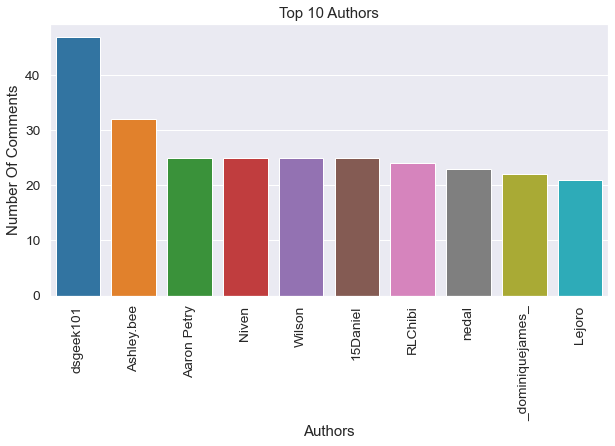

In [8]:
# and graphed... for fun

sns.set_style(style='darkgrid')
sns.set_context('notebook', font_scale=1.25, rc={'lines.linewidth': 2.5})

plt.figure(figsize=(10,5))

ax = sns.barplot(top10.index, top10.values)

labels = ax.set(title='Top 10 Authors',xlabel='Authors', ylabel='Number Of Comments')
ticks = ax.set_xticklabels(ax.get_xticklabels(),rotation=90) # if not assigned to a variable, then prints lots of text

Here we do not want any content from the bot. This gives us random content to look peruse.

In [9]:
content = [_.lower() for _ in df_prog[df_prog['author.isBot']==False]['content']]

import random

random.choices(content, k=30)

["(yesterday) travel day, so very light, but still got some things in! day 11 of #66daysofdata:\n- problem of the day on @leetcode\n- continued @datacamp's 'data manipulation with pandas'",
 'day 2: i finished the last 2 chapters of the course introduction to spark sql in python from datacamp.  it was a little bit difficult the part of sql window functions but... mission completed😉',
 '@ashley.bee what resources have you been using to learn tableau?',
 'electronics',
 'day4/66: completed python for data analysis with pandas',
 'day 14: few hours on java + reading articles, blogs, job offers,, even i found a cheap micro program in data science subsided by my local government, i might do it , it a plus for my cv even though we can find all the content on the net.',
 'day 17: working (part 8 - deploy to production aws) with real estate price prediction project through codebasics yt channel',
 "yes @xcalibur !! i won't contend with just the score i have on titanic right now ... i'll be bac

## Lemmaizing, removing stops words and analysing

In [10]:
# some examples to pick
text1 = 'day 14: went through the first 3 lessons of the deep learning kaggle micro course'
text2 = "day 14: completed kaggle's pandas micro-course"
text3 = '''day 1:  complete the "analyzing police activity with pandas" course on datacamp.'''

#displacy.render(doc, jupyter=True)

for i in random.sample(list(range(len(content))), k=10):
    doc = nlp(content[i])
    noun_list = [token.lemma_ for token in doc if
                not token.is_stop and
                token.pos_ != 'PUNCT']
    output = ' '.join(noun_list)
    print(output)

day 8 
 read article algorithm machine learning
day 5 : 
 perform datum cleaning outlier removal feature generation 
 continue model building turn analysis result expect lesson learn importance project planning jump code
day 8/#66daysofdata 
 today start learn intermediate pandas 
 @datacamp course 
 solve interesting python problem hackerrank improve problem solve skill 
 practice pandas data manipulation skill work interesting chipotle sale dataset
hi guy relatively beginner comment suggestion appreciate :) 
 day 1   continue 5 r z udemy course refresh useful command operation data frame
day 12 lot time today 5 minute quickly revise pipeline
glad set goal @gjysme2
good luck today 🙂 let
day 12 kata c programming unix os class pipeline decision tree
miss day yesterday today d6 # 66daysofdata 

 complete datum visualization course kaggle
day 15 read practical statistic datum scientist


In [11]:
# day matcher

from spacy.matcher import Matcher

pattern_day = [{'LOWER': 'day'},
              {'LIKE_NUM': True}]

matcher = Matcher(nlp.vocab, validate=True)
matcher.add("DayMatcher", None, pattern_day)

days = []
# for i in range(len(content)):
#     doc = nlp(content[i])
#     days.extend([doc[match[1]:match[2]] for match in matcher(doc)])
# len(days)

1227

In [16]:
df_days = pd.DataFrame(days, columns=['test','days'])
df_days['days'].value_counts() # not working, all digits are unique

1     1
3     1
11    1
0     1
1     1
     ..
7     1
01    1
7     1
3     1
1     1
Name: days, Length: 1227, dtype: int64

In [22]:
words = ' '.join(content)
doc = nlp(words)

simplewords = [token.lemma_ for token in doc
                            if not token.is_stop and 
                            not token.is_punct]

,0
0,day1
1,create
2,github
3,repo
4,create


In [51]:
df_sw = pd.DataFrame(simplewords, columns=['word'])
df_sw.value_counts().head(30)

# r_mentions = df_sw[df_sw['word']=='r'].value_counts()
# py_mentions = df_sw[df_sw['word']=='python'].value_counts()
# print(str(r_mentions))
# print(str(py_mentions))


word        
day             1436
\n              1092
course           533
datum            415
learn            402
python           391
kaggle           321
start            311
data             310
1                302
\n\n             273
2                260
complete         253
project          223
work             200
66daysofdata     196
3                194
today            192
learning         184
                 183
pandas           176
machine          176
finish           164
read             158
science          151
>                146
4                135
basic            133
go               121
chapter          119
dtype: int64

## Exploratory Data Analysis - #introductions channel

Find locations and what people do, maybe age as well. Build demographics of the audience

In [13]:
df_intro.shape

(606, 15)

In [14]:
content_intro = [_ for _ in df_intro[df_intro['author.isBot']==False]['content']]

import random

random.choices(content_intro, k=10)

["> Well I have not done much yet. Till now I have completed a Machine Learning course from Coursera and currently I am doing another specialization on deep learning by Andrew Ng. I have not done any real world projects, just some practice course project so I will be greatful if you could suggest me some nice project for beginners.\n@Harsh thats still great progress! I think give @kjee1's videos on sample projects a watch. He goes through end to end design. Once you have skills to do that, create a github and pick a topic that interests you. Then follow the process of extraction, cleaning, etc and document  it on github. Share with others to get their input and ideas on how you can improve and for some constructive criticism 💪",
 'Hi everyone, I’m Mahmoud, an Industrial Engineering student from the US. I want to develop my skills to land a data analyst job when I graduate and eventually move into data science',
 'Hi guys. Learning data science and machine learning for few months. Just 

In [15]:
df.

SyntaxError: invalid syntax (<ipython-input-15-38e9e33c87a8>, line 1)